# Chapter 3: Classification

In [1]:
import numpy as np
import pandas as pd

## MNIST Classification

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- `DESCR` describes the dataset
- `data` array with one row few instance and one column per feature
- `target` array with labels

In [5]:
input_array, output_array = mnist["data"], mnist["target"]

In [6]:
input_array.shape

(70000, 784)

In [7]:
output_array.shape

(70000,)

- 784 features(28 * 28 pixels)
- Intensity if from 0 (white) to 255 (black)

# Visualizing the Numbers

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
example_num = input_array[42]

In [10]:
example_num_image = example_num.reshape(28, 28)

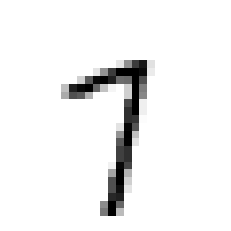

In [11]:
plt.imshow(example_num_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
output_array[42]

'7'

- Change the labels to numerical data

In [13]:
output_array = output_array.astype(np.uint8)

# Split the Data

- Data is already shuffled 

In [14]:
X_train, X_test, y_train, y_test = input_array[:60000], input_array[60000:], output_array[:60000], output_array[60000:]

# Training a Binary Classifier

- Creating an identifier that will predict if an image is `8` or not

- Target vectors the classification class

In [15]:
y_train_8 = (y_train == 8)

In [16]:
y_test_8 = (y_test == 8)

In [17]:
y_train_8

array([False, False, False, ..., False, False,  True])

In [18]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

- Starting off with Stochastic Gradient Descent
    - Can handle very large datasets efficiently
    - Deals with training instances independently, one at a time(makes it good for online learning)

In [19]:
from sklearn.linear_model import SGDClassifier

In [20]:
sgd_clf = SGDClassifier(random_state=42)

In [21]:
sgd_clf.fit(X_train, y_train_8)

SGDClassifier(random_state=42)

# Performance Measures

## Measuring Accuracy Using Cross Validation

## My own Cross Validation

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

- Stratified Sampling to produce folds that contain representative ratio of each class

In [23]:
skfolds = StratifiedKFold(n_splits=3)

## K-Fold Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.909  , 0.9286 , 0.88285])

## Check with Dummy Classifier

In [26]:
from sklearn.base import BaseEstimator

In [27]:
class Never8Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_8_clf = Never8Classifier()

In [29]:
cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.9039 , 0.9031 , 0.90045])

## Confusion Matrix

In [30]:
from sklearn.model_selection import cross_val_predict

- K-fold cross validation that makes a prediction for each test fold(that wasn't seen during training)

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_train_8, y_train_pred)

array([[50006,  4143],
       [ 1448,  4403]])

                Predicted Negative Predicted Positive
Actual Negative True Negative False Positive
Actual Positive False Negative True Positive

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [35]:
precision_score(y_train_8, y_train_pred)

0.515211794991809

In [36]:
recall_score(y_train_8, y_train_pred)

0.7525209365920356

In [37]:
f1_score(y_train_8, y_train_pred)

0.611655205945683

- You can increase precision or recall at the cost of the other. Depends on where you put the threshold to predict a positive case

# Changing the Threshold 

https://stackoverflow.com/questions/20113206/scikit-learn-svc-decision-function-and-predict

In [38]:
y_scores = sgd_clf.decision_function(X_train)

In [39]:
y_scores

array([-12954.44836362,  -9363.44747449, -13106.83874229, ...,
        -4725.07273836, -14258.32600671,   2537.92261952])

In [40]:
threshold = 0

In [41]:
y_some_digit_pred = (y_scores > threshold)

In [42]:
y_some_digit_pred

array([False, False, False, ..., False, False,  True])

In [43]:
np.sum(y_some_digit_pred)

4872

# New Threshold

In [44]:
threshold = 20000

In [45]:
y_some_digit_pred = (y_scores > threshold)

In [46]:
y_some_digit_pred

array([False, False, False, ..., False, False, False])

In [47]:
np.sum(y_some_digit_pred)

0

- So raising the threshold decreases the the recall. Because none were predicted as being True

## Determining the Threshold to Use

- We need to get the decison scores from the model instead of the actual predictions

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3, method="decision_function")

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

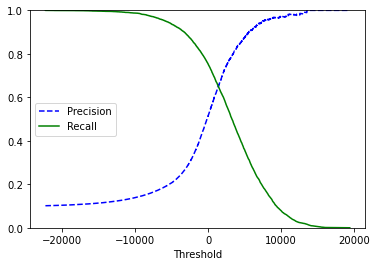

In [52]:
plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)
plt.show()

# Plotting Precision against Recall

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
#     plt.ylim([0,1])

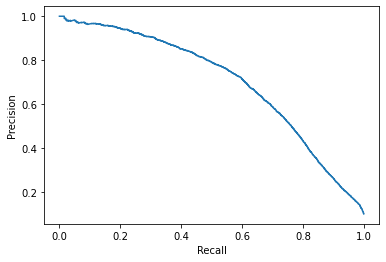

In [54]:
plot_precision_vs_recall(precisions=precisions, recalls=recalls)

# Changing the threshold to get an acceptable Precision or Recall

- Example, we want a model with 90% percision.
- We would go to the threshold curve, and find the threshold where percision is 90. And use that threshold in the model.

In [55]:
y_train_pred_90 = (y_scores > 5000)

In [56]:
precision_score(y_train_8, y_train_pred_90)


0.8751565762004175

In [57]:
recall_score(y_train_8, y_train_pred_90)


0.3582293625021364

# ROC Curve

- ROC Curve: Reciever Operating Characteristic Curve
    - Often used in Binary classification
    - Plots the True Positive Rate againest the False Positive Rate
    - True Positive Rate: Recall or TP / (TP + FN)
    - False Positive Rate: FP / (FP + TN) 
        - FPR: Ratio of negative instances that are inorrectly classified as positive. 1 - True negative rate. (TNR: negatives instances that are correctly classified as negative. The specificity). 
    - AKA plots sensitivity(recall) against 1 - specificity

In [58]:
from sklearn.metrics import roc_curve

In [59]:
fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

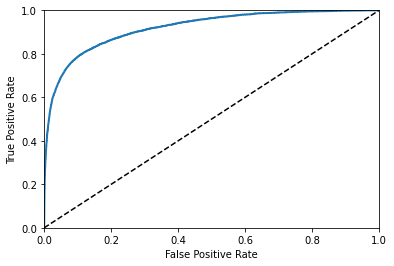

In [61]:
plot_roc_curve(fpr, tpr)
plt.show()

- The higher the recall(TPR), the more false positive are identified. 
- The dotted line is the ROC curve of a purely random classifier. The goal is to stay as far away as you can from the dotted line. 
- You can measure the area under the curve. 

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_train_8, y_scores)

0.9192599874103056

- Use the Precision Recall curve when the positive class is rare or when you care more about the false positives than the false negatives.
- Use the ROC curve for other instances.

In [64]:
from sklearn.ensemble import RandomForestClassifier

- `RandomForestClassifier` does not have a `decision_function()` but instead has a `predict_proba()` method.
- Sklearn classifiers usually have one or the other
- `predict_proba()` returns an array containing a row per instance and a column per class, each containing the probability that a given instance belongs to the class

In [65]:
forest_clf = RandomForestClassifier(random_state=42)

Currently on page: 94